In [27]:
from __future__ import print_function, division

from sklearn import metrics
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pretrainedmodels.utils as utils
import pretrainedmodels
from itertools import chain

from torchviz import make_dot, make_dot_from_trace

%matplotlib inline
plt.ion()   # interactive mode

In [3]:
os.system(os.path.join(data_dir,"split.pl"))

NameError: name 'data_dir' is not defined

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './LittlePlaNet/data/cities/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                           data_transforms[x])
                   for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
               for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
newtestds = datasets.ImageFolder("data/cities/",
                                           data_transforms["test"])
nt_dataloader = torch.utils.data.DataLoader(newtestds,batch_size=4, shuffle=True, num_workers=4)

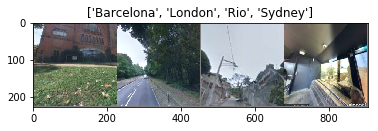

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    hist = {"train":[], "val":[]}
        
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)                    
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            hist[phase] += [[epoch_loss, epoch_acc]]
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, hist

In [6]:
def visualize_model(model, num_images=6, dl = dataloaders['val'], topk= False ):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dl):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if topk:
                _, preds = torch.topk(outputs, 4)
            else:
                _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//3, 3, images_so_far)
                ax.axis('off')
                if topk:
                    ax.set_title('predicted: {}\n actual: {}'.format(
                        " ".join(map(lambda x: class_names[x], list(preds[j]))),
                        class_names[labels[j]]))
                else:
                    ax.set_title('predicted: {}\n actual: {}'.format(class_names[preds[j]],class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
# Do Not rerun this

model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
# model_ft.classifier = nn.Sequential(# last layer to retrain
#      nn.Dropout(p=0.5),
#      nn.Conv2d(512, len(class_names), kernel_size=(1,1),stride=(1,1)),
#      nn.ReLU(inplace=True),
#      nn.AvgPool2d(kernel_size=13, stride=1, padding=0)
# )
model_ft.num_classes = len(class_names)

model_ft = model_ft.to(device)

In [28]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD( chain (model_ft.fc.parameters(), model_ft.layer4.parameters()), lr=0.001, momentum=0.9, nesterov=True)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=4, gamma=0.1)


In [29]:
model_ft, hist_new_2 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 2.0182 Acc: 0.3186
val Loss: 1.5224 Acc: 0.5303

Epoch 1/14
----------
train Loss: 1.7176 Acc: 0.4117
val Loss: 1.5955 Acc: 0.4972

Epoch 2/14
----------
train Loss: 1.5865 Acc: 0.4623
val Loss: 1.7235 Acc: 0.4844

Epoch 3/14
----------
train Loss: 1.5049 Acc: 0.4846
val Loss: 1.3011 Acc: 0.5807

Epoch 4/14
----------
train Loss: 1.2834 Acc: 0.5682
val Loss: 1.3789 Acc: 0.5716

Epoch 5/14
----------
train Loss: 1.2432 Acc: 0.5795
val Loss: 1.2778 Acc: 0.6064

Epoch 6/14
----------
train Loss: 1.2205 Acc: 0.5897
val Loss: 1.2251 Acc: 0.6073

Epoch 7/14
----------
train Loss: 1.1954 Acc: 0.6042
val Loss: 1.3043 Acc: 0.5826

Epoch 8/14
----------
train Loss: 1.1583 Acc: 0.6114
val Loss: 1.2086 Acc: 0.6275

Epoch 9/14
----------
train Loss: 1.1676 Acc: 0.6039
val Loss: 1.2503 Acc: 0.6165

Epoch 10/14
----------
train Loss: 1.1593 Acc: 0.6105
val Loss: 1.2743 Acc: 0.6037

Epoch 11/14
----------
train Loss: 1.1507 Acc: 0.6130
val Loss: 1.2014 Acc: 0.6284

Ep

In [10]:
fig = plt.figure()
model_ft.eval()
j = 1
for phase in ["train","test", "val"]:
    preds = []
    Y = []
    for x,y in dataloaders[phase]:
        _, prs = model_ft(x.to(device)).max(1)
        preds +=list(prs)
        Y += list(y)

    scor = metrics.accuracy_score(Y, preds)
    print(scor)
    ax = plt.subplot(1,3,j)
    ax.axis('off')
    j+=1
    CM = metrics.confusion_matrix(Y,preds)
    ax.matshow(CM.astype(np.double))
    plt.title(phase)

RuntimeError: received 0 items of ancdata

In [31]:
preds = []
Y = []
for x,y in nt_dataloader:
    _, prs = model_ft(x.to(device)).max(1)
    preds +=list(prs)
    Y += list(y)

In [19]:
x,y = next(iter(dataloaders["test"]))

False

0.623
0.6282317996044572


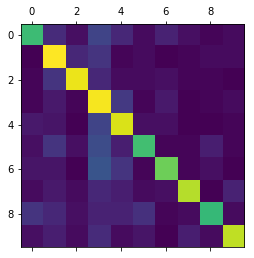

In [32]:
scor = metrics.accuracy_score(Y, preds)
print( scor )
print(metrics.f1_score(Y,preds, average="weighted"))
plt.matshow(metrics.confusion_matrix(Y,preds).astype(np.double))

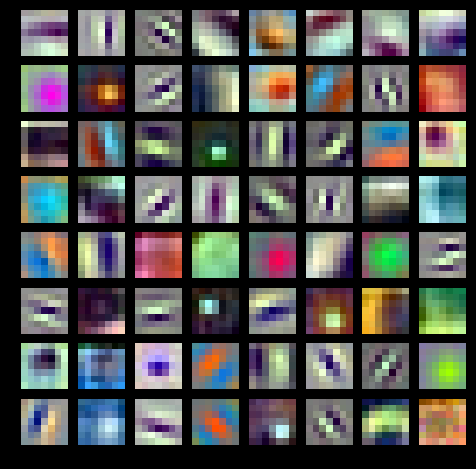

In [26]:
net = model_ft.
figure  = plt.figure(64, (8, 8), facecolor='black')

for panel  in range(0, net.weight.size(0)):
    ax = plt.subplot(8,8, panel+1)
    plt.axis('off')
    data = net.weight[panel]
    data = (data - torch.min(data)) / (torch.max(data) - torch.min(data))
    plt.imshow(  data.transpose(0,1).cpu().transpose(1,2).data.cpu().numpy())
 

In [130]:
# ?optim.Adagrad
res = model_ft(next(iter(dataloaders["train"]))[0].to(device))
res.topk(5)

(tensor([[ 0.7129,  0.5948,  0.5867,  0.0890, -0.4196],
         [ 0.7372,  0.6668,  0.5662,  0.5231,  0.3019],
         [ 5.0213,  2.7090,  1.1255, -0.1423, -0.8110],
         [ 6.0803,  1.9836,  0.3717,  0.1017, -0.5499]], device='cuda:0'),
 tensor([[ 6,  5,  8,  4,  3],
         [ 1,  6,  7,  2,  0],
         [ 5,  1,  3,  2,  0],
         [ 9,  7,  4,  1,  6]], device='cuda:0'))

In [13]:
torch.save(model_ft, "./models/resnet50_trained")

In [10]:
model_ft = torch.load("models/resnet_trained")

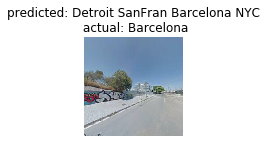

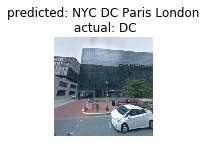

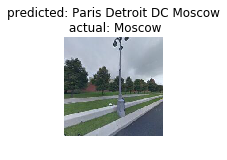

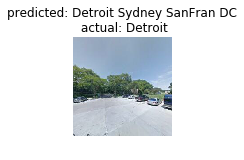

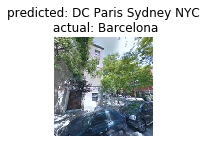

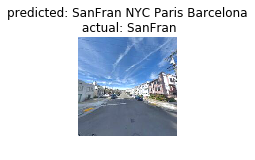

In [18]:
# plt.subplot(num_images//4, 4, images_so_far)
visualize_model(model_ft, 6, nt_dataloader, topk=True)

In [117]:
graph = make_dot(res.mean(),params= dict(model_ft.named_parameters()))
graph.render("out.gz", view=True)

'out.gz.pdf'

In [30]:
iter(model_ft.modules)

TypeError: 'method' object is not iterable

In [153]:
rep = metrics.classification_report(np.asarray(Y), np.asarray(preds), target_names=class_names)
print (rep)


             precision    recall  f1-score   support

  Barcelona       0.35      0.32      0.34       100
         DC       0.51      0.36      0.42       100
    Detroit       0.57      0.70      0.63       100
     London       0.46      0.46      0.46       100
     Moscow       0.36      0.48      0.41       100
        NYC       0.47      0.29      0.36       100
      Paris       0.30      0.31      0.31       100
        Rio       0.45      0.43      0.44       100
    SanFran       0.46      0.49      0.48       100
     Sydney       0.54      0.63      0.58       100

avg / total       0.45      0.45      0.44      1000



In [64]:
import io, re

train = []
val   = []

with io.StringIO(FF) as f:
    for i in range(25):        
        l1 = f.readline()
        f.readline()
        l2 = f.readline()
        l3 = f.readline()
        res = re.search("(\d+)\/",l1)
        res2 = re.findall(": (\d+\.\d+)",l2)
        res3 = re.findall(": (\d+\.\d+)",l3)
        f.readline()
        train += [res2]
        val   += [res3]
    print("done")


done


In [19]:
%matplotlib qt5
hist= hist_new
train = np.asarray(hist["train"])
val = np.asarray(hist["val"])

Text(0,0.5,'Loss')

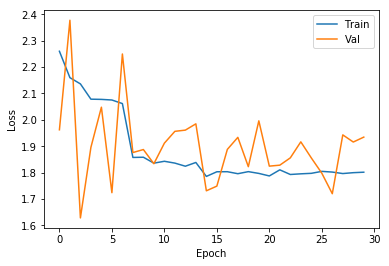

In [22]:
plt.plot(range(30),train[:,0], label = "Train")
plt.plot(range(30),val[:,0], label = "Val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
# plt.yticks(np.arange(1.3,2.3, step=0.2))